In [1]:
# Import packages and set up
import numpy as np
from matplotlib import pyplot as plt
import cv2
import csv
import math
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

The corner extraction for the color and thermal images is performed manually because there are only a handful of images and it would take a longer time to fine-tune and verify the automatic segmentation and corner extraction.

This tool https://yangcha.github.io/iview/iview.html is used to find the coordinates of individual pixels.

In [12]:
therm_coords = []
color_coords = []
base_dir = '/home/ed/Data/2020-07-02-10-16-00_test/'
num_frames = 5
ext = '.png'

# Read in color coords
with open(base_dir + 'color/coords.csv', 'r') as f:
    data = csv.reader(f)
    for row in data:
        color_coords.append([int(row[0]), int(row[1]), 1.0])
        
# Read in therm coords        
with open(base_dir + 'therm/coords.csv', 'r') as f:
    data = csv.reader(f)
    for row in data:
        therm_coords.append([int(row[0]), int(row[1]), 1.0])
        
# Check we have four corner points per image        
assert len(therm_coords) == num_frames * 4
assert len(color_coords) == num_frames * 4

# Transpose to facilitate future matrix operations
therm_coords = np.transpose(np.array(therm_coords))
color_coords = np.transpose(np.array(color_coords))

The frames are saved by running `rosrun image_view image_view image:={color/thermal}/camera/image_{rect_color, raw}_throttle` and right clicking to save. They are then renamed and put in the appropriate directory. Ensure the frames are in ascending, paired order, with the format `n.jpg`.

Show each pair of calibration images side by side with their corresponding hand-picked pixel locations for a sanity check.

Text(0.5, 1.0, 'Color')

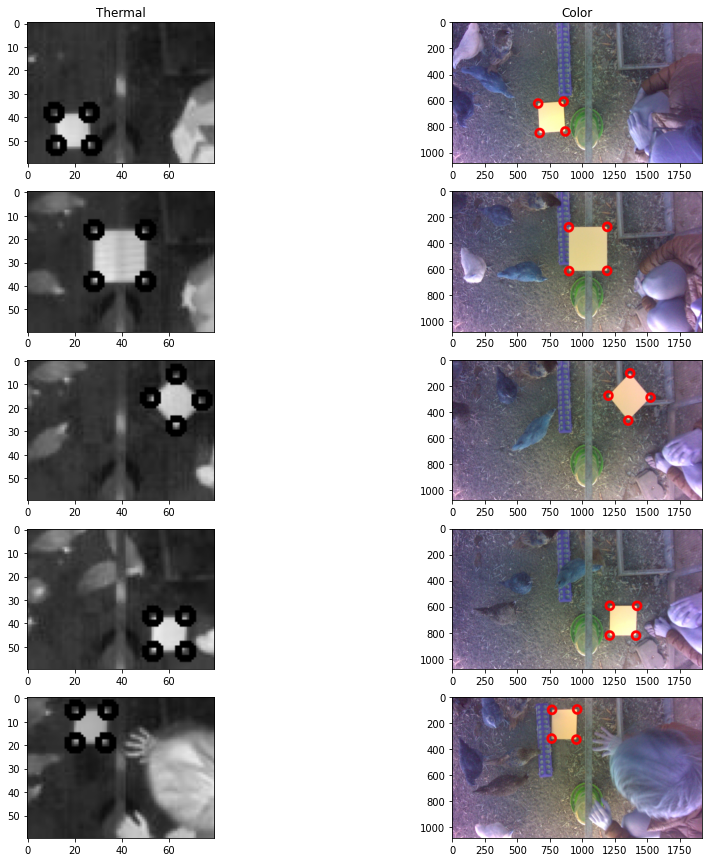

In [13]:
therm_frames = []
color_frames = []

fig, axs = plt.subplots(num_frames, 2, figsize=(15, 15))
for i in range(num_frames):
    therm_frames.append(cv2.imread(base_dir + 'therm/' + str(i) + ext))
    color_frames.append(cv2.imread(base_dir + 'color/' + str(i) + ext))
    for j in range(4): # num corners
        therm_center = (int(therm_coords[0, i*4 + j]), int(therm_coords[1, i*4 + j]))
        therm_frames[i] = cv2.circle(therm_frames[i], therm_center, 3, (0, 0, 0), 2)
        color_center = (int(color_coords[0, i*4 + j]), int(color_coords[1, i*4 + j]))
        color_frames[i] = cv2.circle(color_frames[i], color_center, 30, (255, 0, 0), 20)        
    axs[i, 0].imshow(therm_frames[i])
    axs[i, 1].imshow(color_frames[i])
    
axs[0][0].set_title('Thermal')
axs[0][1].set_title('Color')

The homogeneous transformation in `SE2` is given by $p_c = {T^c_t} p_t$, where $p_c$ is the pixel coordinate in the color frame, $p_t$ is the pixel coordinate in the thermal frame and ${T^c_t}$ is the homogeneous transformation between the two.

Given we are provided both $p_c$ and $p_t$ above, it is possible to calculate ${T^c_t} = p_c{p_t}^{-1}$. 

In [14]:
T_therm_color = np.dot(therm_coords,np.linalg.pinv(color_coords))
T_color_therm = np.linalg.inv(T_therm_color)
print ('T_therm_color\n', T_therm_color, '\n')
print ('T_color_therm\n', T_color_therm)

%store T_color_therm

T_therm_color
 [[  0.073   0.    -37.08 ]
 [  0.001   0.064  -2.043]
 [  0.      0.      1.   ]] 

T_color_therm
 [[ 13.611  -0.019 504.656]
 [ -0.106  15.587  27.913]
 [ -0.     -0.      1.   ]]
Stored 'T_color_therm' (ndarray)


In [15]:
# Calculate the reprojection error
err = 0.0
for i in range(therm_coords.shape[1]):
    p = np.dot(T_color_therm, therm_coords[:, i])
    err += math.sqrt((p[0] - color_coords[0, i])**2 + (p[1] - color_coords[1, i])**2)
err /= therm_coords.shape[1]
print('Average reprojection error (pix):', round(err, 1))

Average reprojection error (pix): 10.6


To verify this result visually, take the coordinates of a random thermal calibration pixel and project it onto the corresponding pixel in the color image. 